In [2]:
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Dataset Class
class GridGraphDataset(Dataset):
    def __init__(self, num_samples, grid_size, noise_level):
        self.num_samples = num_samples
        self.grid_size = grid_size
        self.noise_level = noise_level
        self.graphs = []
        self.prepare_data()
        
    def prepare_data(self):
        for _ in range(self.num_samples):
            # Generate a grid graph
            G = nx.grid_2d_graph(self.grid_size, self.grid_size)
            # Convert to adjacency matrix
            A = nx.to_numpy_array(G)
            # Add noise to the adjacency matrix
            A = self.add_noise(A, self.noise_level)
            # Prepare expanded adjacency matrix (same graph twice)
            A_expanded = self.create_expanded_adjacency(A, A)
            # Prepare node features
            node_features = self.create_node_features(A.shape[0])
            # Store the data
            self.graphs.append({
                'A_expanded': A_expanded,
                'node_features': node_features,
                'target': A  # The original adjacency matrix
            })
        
    def add_noise(self, A, noise_level):
        # Add noise to the adjacency matrix
        # For simplicity, let's flip some entries
        A_noisy = A.copy()
        num_entries = A.shape[0] * A.shape[1]
        num_noisy_entries = int(noise_level * num_entries)
        indices = np.random.choice(num_entries, num_noisy_entries, replace=False)
        # Flip the entries at the selected indices
        A_noisy.flat[indices] = 1 - A_noisy.flat[indices]
        # make sure that symmetric
        A_noisy = (np.tril(A_noisy) + np.tril(A_noisy).T).clip(0, 1)
        return A_noisy
        
    def create_expanded_adjacency(self, A_noisy, A_conditioning):
        # Stack the adjacency matrices to create an expanded adjacency matrix
        A_expanded = np.block([
            [A_noisy, np.zeros_like(A_noisy)],
            [np.zeros_like(A_noisy), A_conditioning]
        ])
        return A_expanded
    
    def create_node_features(self, k):
        # Create node features of size 2k
        # For simplicity, use ones
        node_features = np.ones(2*k)
        return node_features
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        data = self.graphs[idx]
        A_expanded = data['A_expanded']
        node_features = data['node_features']
        target = data['target']
        return torch.tensor(A_expanded, dtype=torch.float32), \
               torch.tensor(node_features, dtype=torch.float32), \
               torch.tensor(target, dtype=torch.float32)

from torch.nn import functional as F

# Hyperparameters
num_samples = 1000
grid_size = 5  # Grid graph of size 5x5
noise_level = 0.05
batch_size = 32
num_epochs = 10
learning_rate = 1e-3

# Prepare Dataset and DataLoader
dataset = GridGraphDataset(num_samples=num_samples, grid_size=grid_size, noise_level=noise_level)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize Model, Loss Function, and Optimizer
k = grid_size * grid_size  # Number of nodes in the grid graph
# model = SimpleAdjacencyDenoiser(k)

from diffalign.neuralnet.transformer_model_with_y import GraphTransformerWithYAtomMapPosEmb, GraphTransformerWithY
output_dims = {'X': 2, 'E': 2, 'y': 1}
hidden_mlp_dims = {'X': 16, 'E': 16, 'y':16, 'dx': 16, 'de': 16, 'dy': 16}
hidden_dims = {'X': 16, 'E': 16, 'y':16, 'dx': 16, 'de': 16, 'dy': 16, 'n_head': 1, 'dim_ffX': 16, 'dim_ffE': 16, 'dim_ffy': 16}
input_dims = {'X': 2, 'E': 2, 'y': 1}

ModuleNotFoundError: No module named 'diffalign.neuralnet.transformer_model_with_y'

In [3]:
model = GraphTransformerWithY(n_layers=2, 
                              input_dims=input_dims, 
                              hidden_mlp_dims=hidden_mlp_dims, 
                              hidden_dims=hidden_dims, 
                              output_dims=output_dims, 
                              act_fn_in=torch.nn.ReLU(),
                             act_fn_out=torch.nn.ReLU(), 
                             improved=False, 
                             dropout=0.1)

In [4]:
from types import SimpleNamespace

# Define a simple config object
class SimpleConfig:
    def __init__(self):
        self.neuralnet = SimpleNamespace()
        self.neuralnet.skip_connection_on_non_mapped_atoms = False

# Create an instance of the simple config
cfg = SimpleConfig()

from diffalign.neuralnet.transformer_model_with_y import GraphTransformerWithYAtomMapPosEmbInefficient
output_dims = {'X': 2, 'E': 2, 'y': 1}
hidden_mlp_dims = {'X': 16, 'E': 16, 'y':16, 'dx': 16, 'de': 16, 'dy': 16}
hidden_dims = {'X': 16, 'E': 16, 'y':16, 'dx': 16, 'de': 16, 'dy': 16, 'n_head': 1, 'dim_ffX': 16, 'dim_ffE': 16, 'dim_ffy': 16}
pos_enc_dim = 8
input_dims = {'X': 2, 'E': 2, 'y': 1}

# Now we can use this cfg object with GraphTransformerWithYAtomMapPosEmb
model_am = GraphTransformerWithYAtomMapPosEmbInefficient(
    n_layers=2, 
    input_dims=input_dims, 
    hidden_mlp_dims=hidden_mlp_dims, 
    hidden_dims=hidden_dims, 
    output_dims=output_dims, 
    act_fn_in=torch.nn.ReLU(), 
    act_fn_out=torch.nn.ReLU(), 
    cfg=cfg,  # Pass the cfg object here
    improved=False, 
    dropout=0.1,
    p_to_r_skip_connection=True,
    alignment_type='correct',
    p_to_r_init=100.,
)

In [5]:
def forward_sample(X, E, t, T):
    # X: (bs, n, d)
    # E: (bs, n, n, d)
    # t: (bs, 1)
    # T: int
    # return 'noised' X and E, that is, individual elements turned to 0 with probability t/T
    bs, n, d = X.shape
    mask_X = torch.rand(bs, n, 1) > (t.reshape(-1, 1, 1) / T)
    mask_E = torch.rand(bs, n, n, 1) > (t.reshape(-1, 1, 1, 1) / T)
    
    X_noised = X * mask_X
    E_noised = E * mask_E
    
    # make sure that symmetric
    E_noised = (torch.tril(E_noised) + torch.tril(E_noised).transpose(1, 2)).clip(0, 1)
    
    return X_noised, E_noised


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        A_expanded, node_features, target = batch
        A_expanded = F.one_hot(A_expanded.long(), num_classes=2).float()
        node_features = F.one_hot(node_features.long(), num_classes=2).float()
        # A_expanded: (batch_size, 2k, 2k)
        # node_features: (batch_size, 2k)
        # target: (batch_size, k, k)
        bs, n = A_expanded.shape[0], A_expanded.shape[1]

        # noising        
        t = torch.randint(0, 20, (bs, 1))
        node_features[:, :k], A_expanded[:, :k, :k] = forward_sample(node_features[:, :k], A_expanded[:, :k, :k], t=t, T=20)
        
        optimizer.zero_grad()
        
        output = model(node_features, A_expanded, 
                       y=torch.zeros(bs, 1), atom_charges=torch.zeros(bs, n, 0), 
                       atom_chiral=torch.zeros(bs, n, 0), 
                       bond_dirs=torch.zeros(bs, n, n, 0), 
                       node_mask=torch.ones(bs, n))
        X, E, y, atom_charges, atom_chiral, bond_dirs, node_mask = output
        # output: (batch_size, 2k, 2k)bs,
        
        # Extract the upper-left k x k block from the output and target
        denoised_output = E[:, :k, :k]
        denoised_target = target
        last_dim = denoised_output.shape[-1]
        
        # Compute the loss
        loss = criterion(denoised_output.reshape(-1, last_dim), denoised_target.reshape(-1).long())
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.2518
Epoch 2/10, Loss: 0.1899
Epoch 3/10, Loss: 0.1756
Epoch 4/10, Loss: 0.1752
Epoch 5/10, Loss: 0.1665
Epoch 6/10, Loss: 0.1694
Epoch 7/10, Loss: 0.1669
Epoch 8/10, Loss: 0.1658
Epoch 9/10, Loss: 0.1681
Epoch 10/10, Loss: 0.1683


In [ ]:
# TODO: check if the predictions of the denoiser are close to the marginal distirbution of the labels?

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_am.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        A_expanded, node_features, target = batch
        A_expanded = F.one_hot(A_expanded.long(), num_classes=2).float()
        node_features = F.one_hot(node_features.long(), num_classes=2).float()
        # A_expanded: (batch_size, 2k, 2k)
        # node_features: (batch_size, 2k)
        # target: (batch_size, k, k)
        bs, n = A_expanded.shape[0], A_expanded.shape[1]

        # noising        
        t = torch.randint(0, 20, (bs, 1))
        node_features[:, :k], A_expanded[:, :k, :k] = forward_sample(node_features[:, :k], A_expanded[:, :k, :k], t=t, T=20)
        
        optimizer.zero_grad()
        atom_map_numbers = torch.zeros(bs, n)
        atom_map_numbers[:, :k] = torch.arange(k)
        atom_map_numbers[:, k:] = torch.arange(k)
        pos_encodings = torch.randn(bs, k, pos_enc_dim)
        pos_encodings = torch.cat([pos_encodings, pos_encodings], dim=1)
        mol_assignment = torch.zeros(bs, n)
        mol_assignment[:, :k] = 0
        mol_assignment[:, k:] = 1
        
        output = model_am(node_features, A_expanded, 
                       y=torch.zeros(bs, 1), atom_charges=torch.zeros(bs, n, 0), 
                       atom_chiral=torch.zeros(bs, n, 0), 
                       bond_dirs=torch.zeros(bs, n, n, 0), 
                       node_mask=torch.ones(bs, n),
                       atom_map_numbers=atom_map_numbers, pos_encodings=pos_encodings, mol_assignment=mol_assignment)
        X, E, y, atom_charges, atom_chiral, bond_dirs, node_mask = output
        # output: (batch_size, 2k, 2k)bs,
        
        # Extract the upper-left k x k block from the output and target
        denoised_output = E[:, :k, :k]
        denoised_target = target
        last_dim = denoised_output.shape[-1]
        
        # Compute the loss
        loss = criterion(denoised_output.reshape(-1, last_dim), denoised_target.reshape(-1).long())
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.0289
Epoch 2/10, Loss: 0.0218
Epoch 3/10, Loss: 0.0182
Epoch 4/10, Loss: 0.0150
Epoch 5/10, Loss: 0.0144
Epoch 6/10, Loss: 0.0137
Epoch 7/10, Loss: 0.0130
Epoch 8/10, Loss: 0.0136
Epoch 9/10, Loss: 0.0131
Epoch 10/10, Loss: 0.0130


In [8]:

def sample_reverse_process_am(model, T, condition_graph, condition_node_features):
    bs, k = condition_graph.shape[0], condition_graph.shape[1]
    E = torch.zeros(bs, 2*k, 2*k)
    E[:, k:, k:] = condition_graph
    X = torch.zeros(bs, 2*k)
    X[:, k:] = condition_node_features
    
    atom_map_numbers = torch.zeros(bs, 2*k)
    atom_map_numbers[:, :k] = torch.arange(k)
    atom_map_numbers[:, k:] = torch.arange(k)
    pos_encodings = torch.randn(bs, k, pos_enc_dim)
    pos_encodings = torch.cat([pos_encodings, pos_encodings], dim=1)
    mol_assignment = torch.zeros(bs, 2*k)
    mol_assignment[:, :k] = 0
    mol_assignment[:, k:] = 1
    
    for t in range(T-1, -1, -1):
        output = model(F.one_hot(X.long(), num_classes=2).float(), F.one_hot(E.long(), num_classes=2).float(), 
                        y=torch.zeros(bs, 1), atom_charges=torch.zeros(bs, n, 0), 
                        atom_chiral=torch.zeros(bs, 2*k, 0), 
                        bond_dirs=torch.zeros(bs, 2*k, 2*k, 0), 
                        node_mask=torch.ones(bs, 2*k),
                        atom_map_numbers=atom_map_numbers, pos_encodings=pos_encodings, mol_assignment=mol_assignment)
        X_output, E_output, y, atom_charges, atom_chiral, bond_dirs, node_mask = output
        
        X_prob, E_prob = reverse_probs_from_X_E_outputs(X_output, E_output, X, E, t, T)
        
        # Sample X according to X_prob
        X = torch.multinomial(X_prob.view(-1, 2), num_samples=1).view(bs, n)
        
        # Sample E according to E_prob
        E = torch.multinomial(E_prob.view(-1, 2), num_samples=1).view(bs, n, n)
        
        # Ensure E is symmetric
        E = torch.tril(E, diagonal=-1)
        E = E + E.transpose(1, 2)
        
    return X, E


def sample_reverse_process(model, T, condition_graph, condition_node_features):
    bs, k = condition_graph.shape[0], condition_graph.shape[1]
    E = torch.zeros(bs, 2*k, 2*k)
    E[:, k:, k:] = condition_graph
    X = torch.zeros(bs, 2*k)
    X[:, k:] = condition_node_features
    
    for t in range(T-1, -1, -1):
        output = model(F.one_hot(X.long(), num_classes=2).float(), F.one_hot(E.long(), num_classes=2).float(), 
                        y=torch.zeros(bs, 1), atom_charges=torch.zeros(bs, n, 0), 
                        atom_chiral=torch.zeros(bs, 2*k, 0), 
                        bond_dirs=torch.zeros(bs, 2*k, 2*k, 0), 
                        node_mask=torch.ones(bs, 2*k))
        X_output, E_output, y, atom_charges, atom_chiral, bond_dirs, node_mask = output
        
        X_prob, E_prob = reverse_probs_from_X_E_outputs(X_output, E_output, X, E, t, T)
        
        # Sample X according to X_prob
        X = torch.multinomial(X_prob.view(-1, 2), num_samples=1).view(bs, n)
        
        # Sample E according to E_prob
        E = torch.multinomial(E_prob.view(-1, 2), num_samples=1).view(bs, n, n)
        
        # Ensure E is symmetric
        E = torch.tril(E, diagonal=-1)
        E = E + E.transpose(1, 2)
        
    return X, E

def reverse_probs_from_X_E_outputs(X_denoised, E_denoised, X_noised, E_noised, t, T):
    # X_denoised, E_denoised: (bs, n, d) ()
    # X_noised, E_noised: (bs, n, d)
    # return: (p(X_t-1|X_t), p(E_t-1|E_t))
    X_prob = torch.softmax(X_denoised, dim=-1)
    E_prob = torch.softmax(E_denoised, dim=-1)
    
    # sum q(X_t-1|X_t,x_0)p(x_0|x_t),  q(X_t|X_t-1)q(x_t-1|x_0)p(x_0|x_t) = (1-1/(T-t+1)) * (1-t/T) * p(x_0|x_t) for not mask
    # 1 - that for mask
    prob_to_not_mask_forward = (1 - 1/(T-t+1)) #* (1 - t/T)
    prob_to_mask_forward = 1 - prob_to_not_mask_forward
    
    # simplified reverse process
    # X_prob[:,:,1:] *= prob_to_not_mask_forward
    # X_prob[:,:,0] = 1 - X_prob[:,:,1:].sum(dim=-1)
    
    # E_prob[:,:,:,1:] *= prob_to_not_mask_forward
    # E_prob[:,:,:,0] = 1 - E_prob[:,:,:,1:].sum(dim=-1)
    
    return X_prob, E_prob


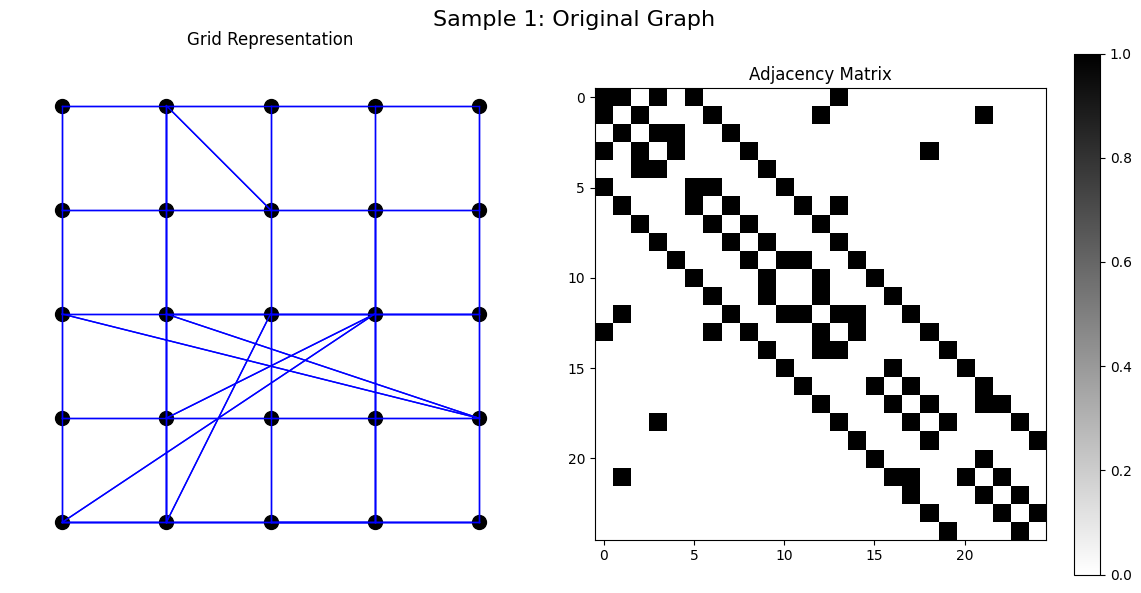

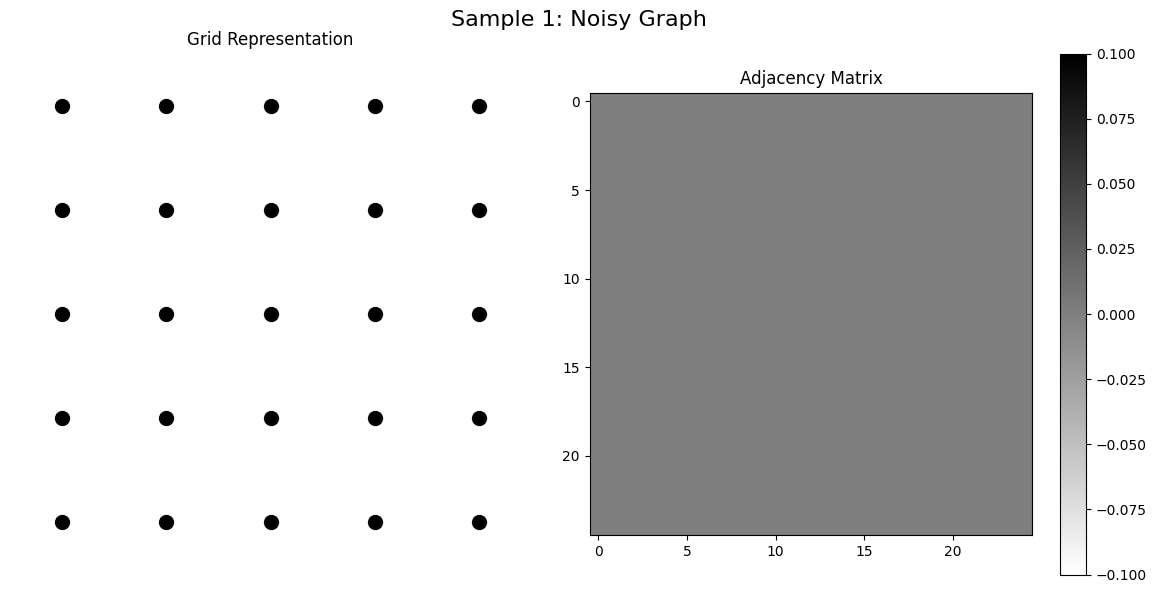

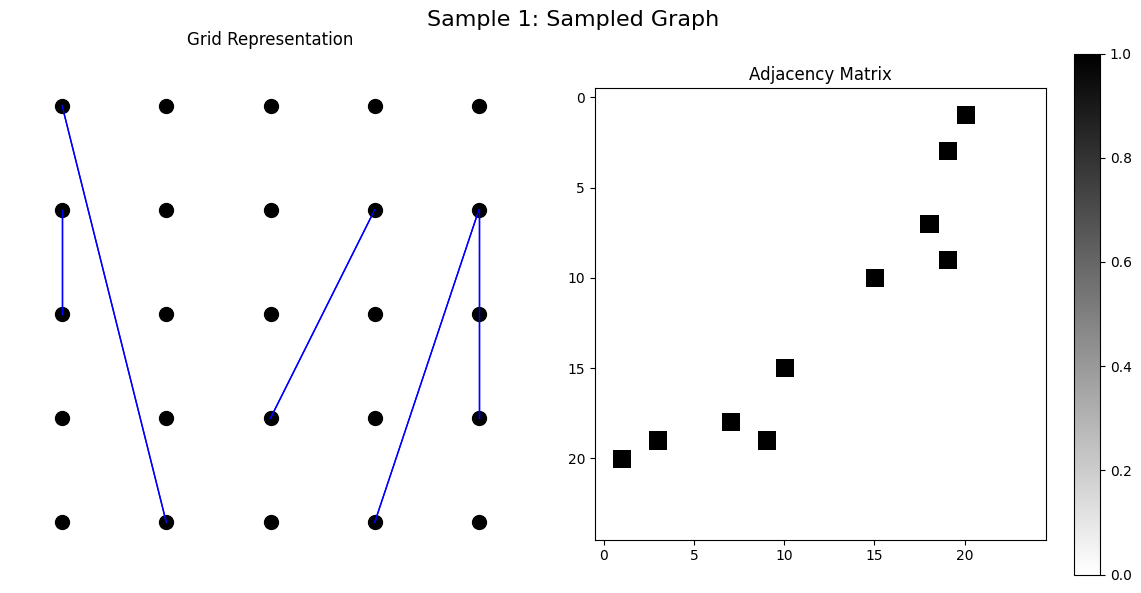

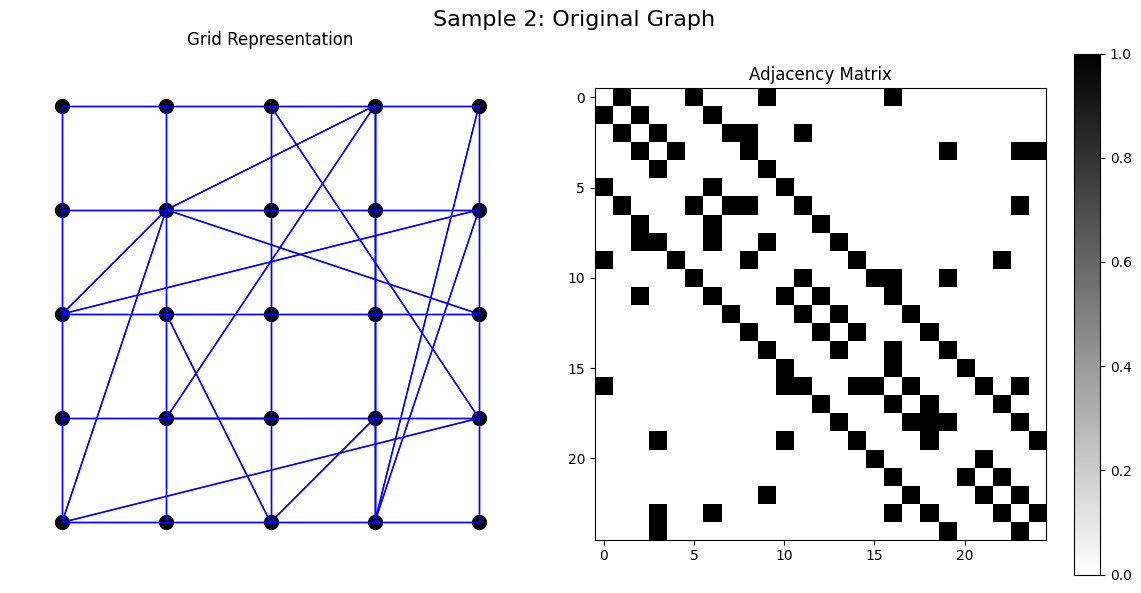

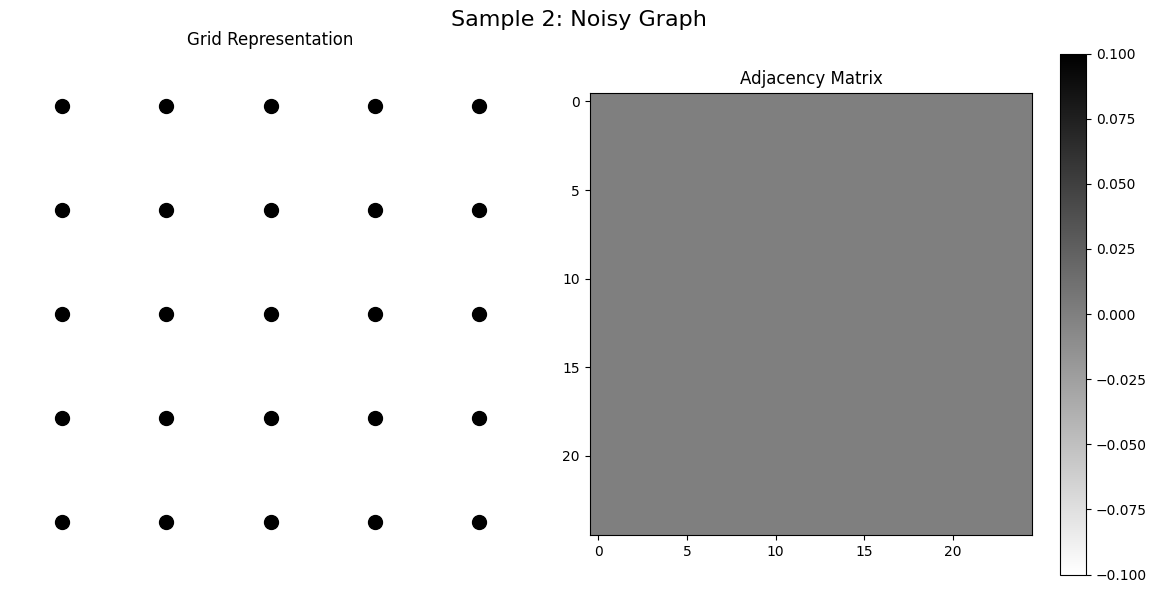

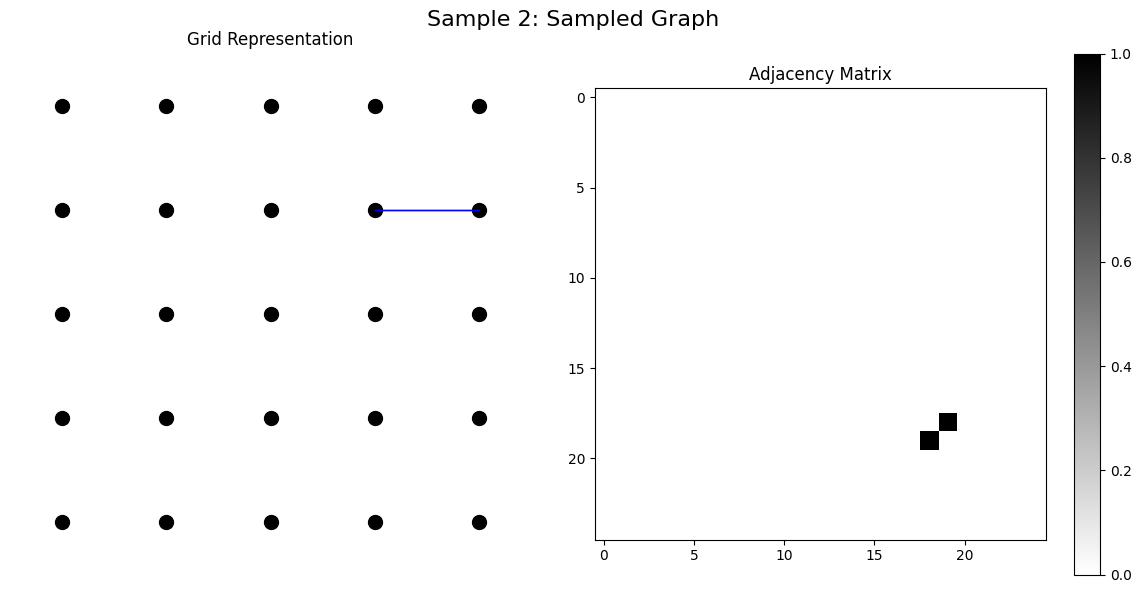

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_grid_graph(adjacency_matrix, title):
    """
    Visualize a grid graph based on the adjacency matrix.
    
    Args:
    adjacency_matrix (numpy.ndarray): A 2D numpy array representing the adjacency matrix.
    title (str): The title for the plot.
    """
    n = adjacency_matrix.shape[0]
    grid_size = int(np.sqrt(n))
    
    # Create a new figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the grid
    for i in range(n):
        row = i // grid_size
        col = i % grid_size
        ax1.plot(col, row, 'ko', markersize=10)
        
        for j in range(n):
            if adjacency_matrix[i, j] > 0.5:  # Assuming binary adjacency matrix
                target_row = j // grid_size
                target_col = j % grid_size
                ax1.plot([col, target_col], [row, target_row], 'b-', linewidth=1)
    
    ax1.set_xlim(-0.5, grid_size-0.5)
    ax1.set_ylim(-0.5, grid_size-0.5)
    ax1.set_aspect('equal', adjustable='box')
    ax1.axis('off')
    ax1.set_title("Grid Representation")
    
    # Plot the adjacency matrix
    im = ax2.imshow(adjacency_matrix, cmap='binary')
    ax2.set_title("Adjacency Matrix")
    
    # Add colorbar
    plt.colorbar(im, ax=ax2)
    
    # Set the main title
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()


# Conditional sampling with the trained model
model.eval()
with torch.no_grad():
    for i in range(2):  # Sample 5 times
        A_expanded, node_features, target = dataset[i]
        A_expanded = A_expanded[None].float()
        node_features = node_features[None].float()
        
        # Sample using reverse process
        sampled_node_features, sampled_A = sample_reverse_process(
            model,
            100,
            A_expanded[:, k:, k:],
            node_features[:, k:],
        )
        
        # Visualize original, noisy, and sampled graphs
        original_A = target.numpy()
        noisy_A = A_expanded[0, :k, :k].numpy() * 0
        sampled_A = sampled_A[0, :k, :k].numpy()
        
        visualize_grid_graph(original_A, f"Sample {i+1}: Original Graph")
        visualize_grid_graph(noisy_A, f"Sample {i+1}: Noisy Graph")
        visualize_grid_graph(sampled_A, f"Sample {i+1}: Sampled Graph")
        
        print("\n" + "="*50 + "\n")

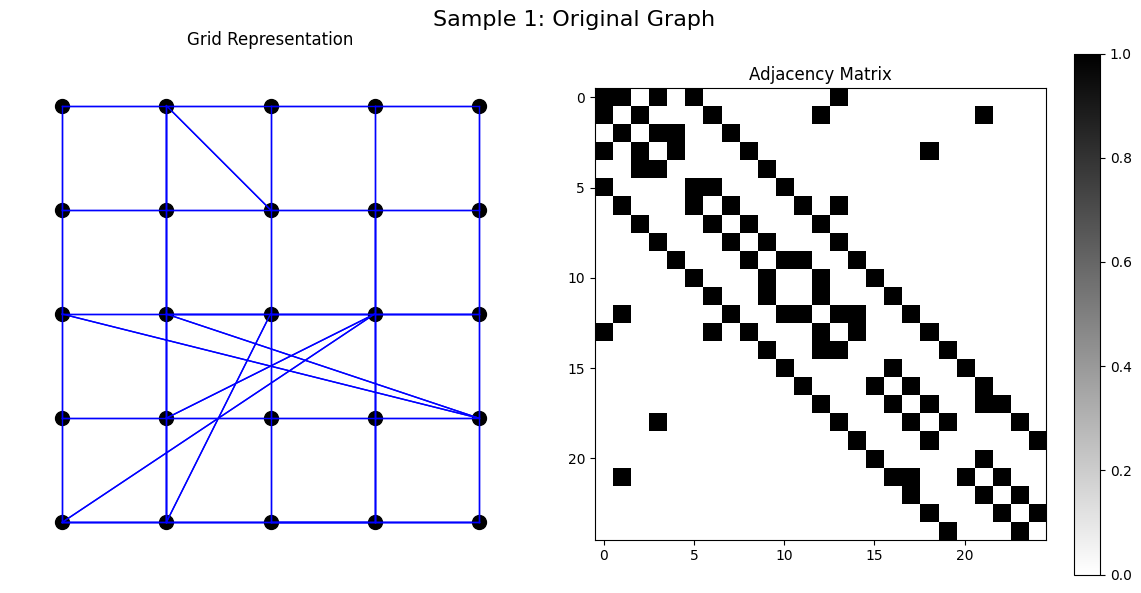

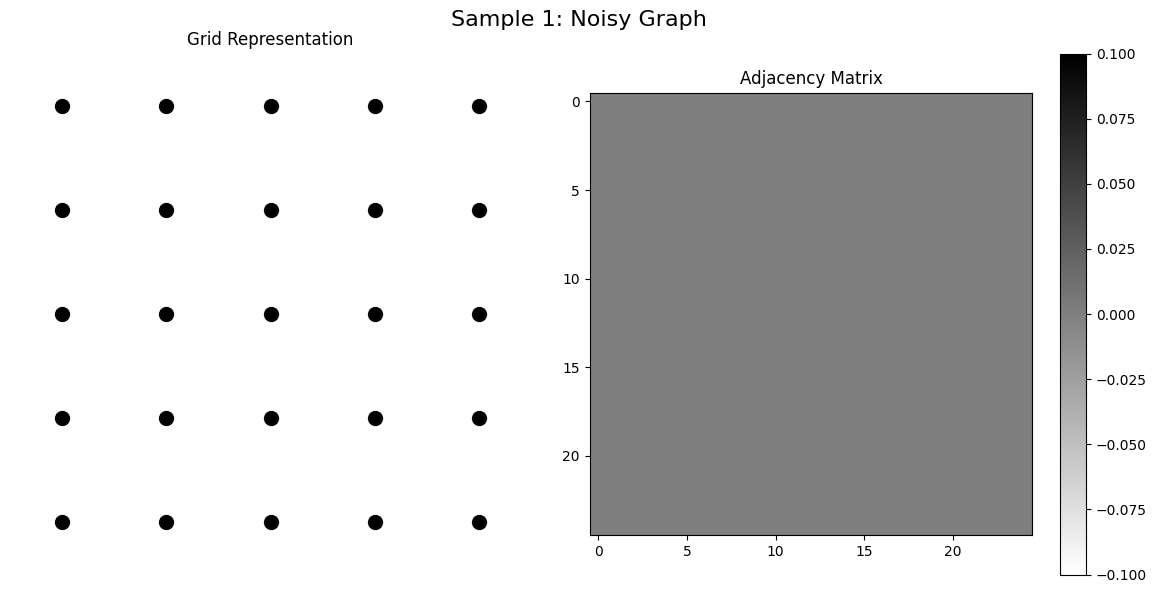

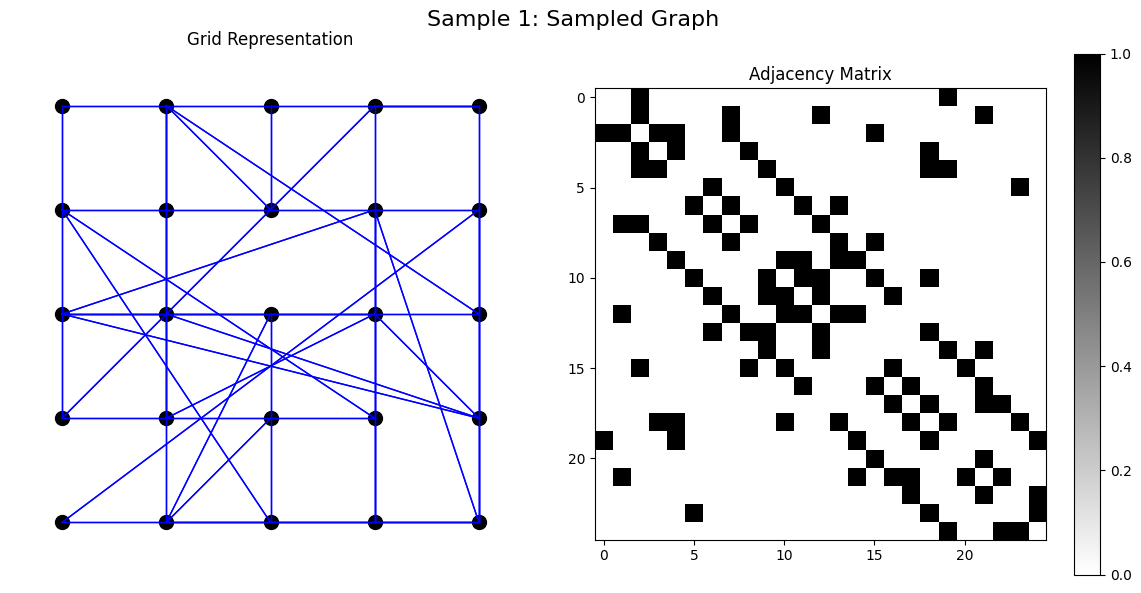

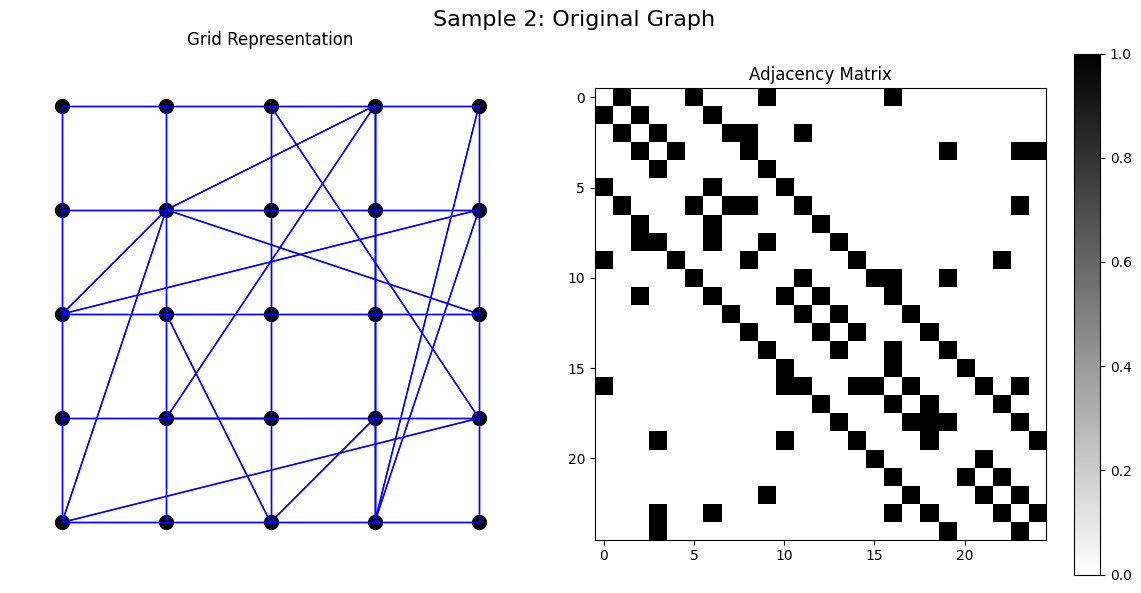

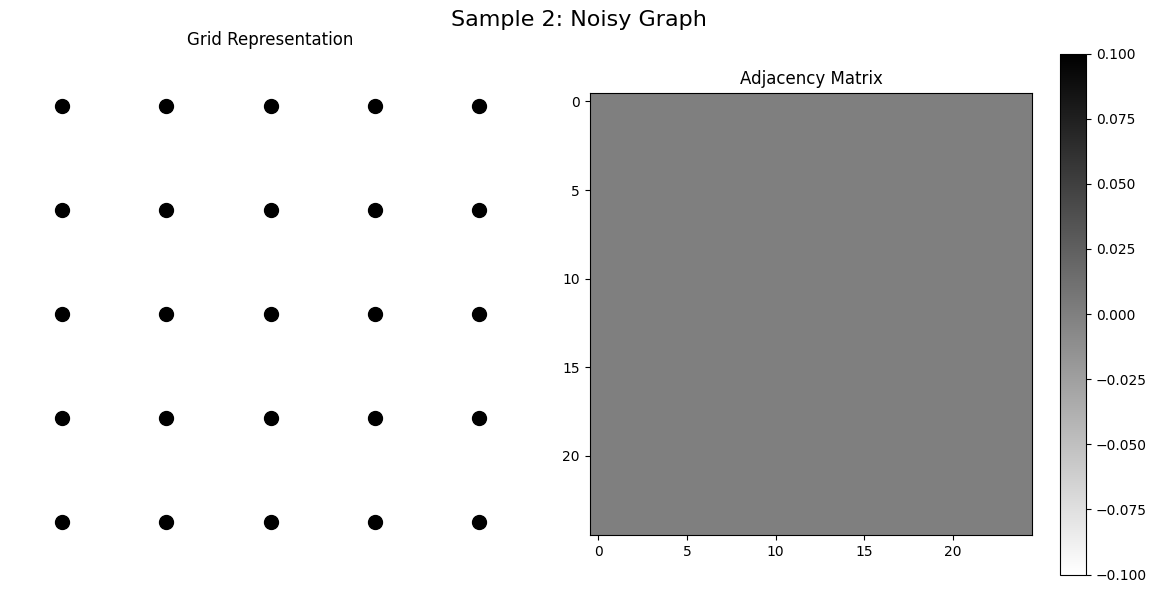

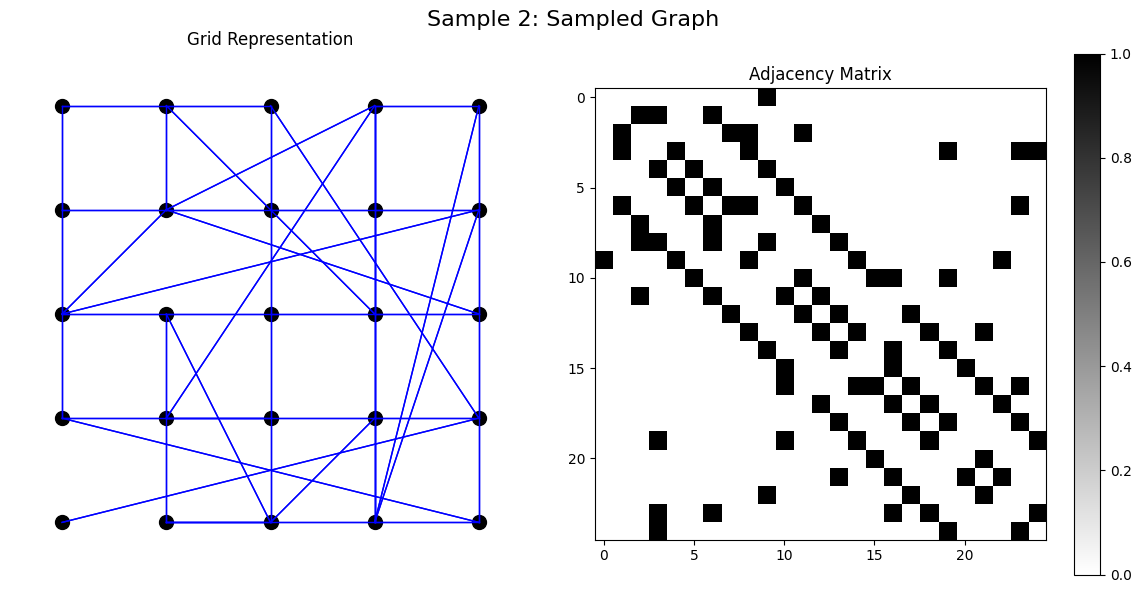

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_grid_graph(adjacency_matrix, title):
    """
    Visualize a grid graph based on the adjacency matrix.
    
    Args:
    adjacency_matrix (numpy.ndarray): A 2D numpy array representing the adjacency matrix.
    title (str): The title for the plot.
    """
    n = adjacency_matrix.shape[0]
    grid_size = int(np.sqrt(n))
    
    # Create a new figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the grid
    for i in range(n):
        row = i // grid_size
        col = i % grid_size
        ax1.plot(col, row, 'ko', markersize=10)
        
        for j in range(n):
            if adjacency_matrix[i, j] > 0.5:  # Assuming binary adjacency matrix
                target_row = j // grid_size
                target_col = j % grid_size
                ax1.plot([col, target_col], [row, target_row], 'b-', linewidth=1)
    
    ax1.set_xlim(-0.5, grid_size-0.5)
    ax1.set_ylim(-0.5, grid_size-0.5)
    ax1.set_aspect('equal', adjustable='box')
    ax1.axis('off')
    ax1.set_title("Grid Representation")
    
    # Plot the adjacency matrix
    im = ax2.imshow(adjacency_matrix, cmap='binary')
    ax2.set_title("Adjacency Matrix")
    
    # Add colorbar
    plt.colorbar(im, ax=ax2)
    
    # Set the main title
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Conditional sampling with the trained model
model.eval()
with torch.no_grad():
    for i in range(2):  # Sample 5 times
        A_expanded, node_features, target = dataset[i]
        A_expanded = A_expanded[None].float()
        node_features = node_features[None].float()
        
        # Sample using reverse process
        sampled_node_features, sampled_A = sample_reverse_process_am(
            model_am,
            20,
            A_expanded[:, k:, k:],
            node_features[:, k:],
        )
        
        # Visualize original, noisy, and sampled graphs
        original_A = target.numpy()
        noisy_A = A_expanded[0, :k, :k].numpy() * 0
        sampled_A = sampled_A[0, :k, :k].numpy()
        
        visualize_grid_graph(original_A, f"Sample {i+1}: Original Graph")
        visualize_grid_graph(noisy_A, f"Sample {i+1}: Noisy Graph")
        visualize_grid_graph(sampled_A, f"Sample {i+1}: Sampled Graph")
        
        print("\n" + "="*50 + "\n")